# Aula 3_4 - BERT

Nome: Lucas Couto Lima RA: 220696

## Instruções:


Criar um modelo de linguagem e medir a perplexidade utilizando o dataset do Machado de Assis, utilizando Embeddings gerados por um BERT pré-treinado e uma MLP.

- Deve-se implementar o próprio laço de treinamento. **Não usar frameworks de treinamento automático.**
- Utilizar o BertModel.from_pretrained e BertTokenizer.from_pretrained do Hugging Face para carregar o BERT pré-treinado.
- Não utilize outras classes da HuggingFace/Transformers alem da [BertModel](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel) e [BertTokenizer](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizer).
- Trabalhe no espaço dos tokens/inteiros. Uma forma de fazer isso é tokenizar o dataset inteiro como pré-processamento.
- Experimente com aumentar o contexto e congelar ou não os parâmetros do BERT. Cuidado que o contexto é o maior fator para o peso computacional aqui.
- Sugerimos utilizar um BERT treinado em português como o BerTimbau: "neuralmind/bert-base-portuguese-cased".
- Inicialmente utilizar o hidden_state do token CLS. Podem experimentar com outras formas de usar o last_hidden_state.
- MLP deve utilizar o vocab_size do BERT na saída. Isso gera um grande desafio de manter o tamanho da MLP razoável.
- Deixe para usar GPU somente quando tudo estiver validado em parte pequena do dataset. Uma época pode demorar 30 minutos ou mais no dataset inteiro.

Opcional:
- Utilize bfloat16 para economizar memória da GPU.

In [ ]:
import random
import torch
import torch.nn.functional as F
import numpy as np

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Tokenizer
-Testar com strings\
-Tokens especiais\
-Tokenize\
-Decode\
-Batch e padding


In [ ]:
from transformers import BertTokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

## Forward no modelo
Inspecionar modelo com torchinfo\
Visualizar saida do modelo

In [ ]:
!pip install torchinfo -q

In [ ]:
import torchinfo
from transformers import BertModel

In [ ]:
model = BertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
# O que esta dentro da classe?
torchinfo.summary(model,
                  input_data=tokenizer("Hello BERT, I am inspecting the model!", return_tensors='pt').input_ids,
                  depth=3)

Layer (type:depth-idx)                                  Output Shape              Param #
BertModel                                               [1, 768]                  --
├─BertEmbeddings: 1-1                                   [1, 16, 768]              --
│    └─Embedding: 2-1                                   [1, 16, 768]              22,881,792
│    └─Embedding: 2-2                                   [1, 16, 768]              1,536
│    └─Embedding: 2-3                                   [1, 16, 768]              393,216
│    └─LayerNorm: 2-4                                   [1, 16, 768]              1,536
│    └─Dropout: 2-5                                     [1, 16, 768]              --
├─BertEncoder: 1-2                                      [1, 16, 768]              --
│    └─ModuleList: 2-6                                  --                        --
│    │    └─BertLayer: 3-1                              [1, 16, 768]              7,087,872
│    │    └─BertLayer: 3-2        

## Dados

Vamos usar o mesmo dataset do Machado de Assis.



In [ ]:
!git clone https://github.com/ethelbeluzzi/projetomachado

Cloning into 'projetomachado'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 65 (delta 24), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (65/65), 7.21 MiB | 2.92 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [ ]:
import os

DATA_PATH = os.path.join("projetomachado", "textonormalizado1000.txt")

# A príncipio, não estamos limpando as linhas
with open(DATA_PATH, "r") as data_file:
    lines = [line for line in data_file]

# É possível voltar a um texto monolítico juntando as linhas.
full_data = ' '.join(lines)
#full_data = full_data[:100000] # Limitando para testes
full_data = tokenizer(full_data).input_ids[1:-1]
len(full_data)

4903405

In [ ]:
from sklearn.model_selection import train_test_split
train_text, val_text = train_test_split(full_data, test_size=0.2, random_state=18, shuffle=False)
len(train_text), len(val_text)

(3922724, 980681)

## Classe do dataset

Utilize o Tokenizer do Bert na classe Dataset.
Defina um tamanho de sequencia/contexto.

In [ ]:
from torch.utils.data import Dataset

context_size = 5 # 5 palavras de entrada. O target é a próxima palavra
"""TODO: Preparar o dataset"""
class TextDataset(Dataset):
    def __init__(self, text, context_size):
        self.pairs = self.create_context_target_pairs(text, context_size)

    def create_context_target_pairs(self, text, context_size):
        context_target_pairs = []

        # Gerar pares (contexto, target) ignorando targets desconhecidos
        for i in range(len(text) - context_size):
            context = text[i:i + context_size]
            target = text[i + context_size]

            # Adiciona o par apenas se o target não for unknown (100)
            if target != 100:
                context = [101] + context + [102]  # concatena listas de inteiros
                context_target_pairs.append((context, target))

        return context_target_pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        context, target = self.pairs[idx]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

In [ ]:
"""TODO: implemente a classe do dataset"""

train_data = TextDataset(train_text, context_size)
val_data = TextDataset(val_text, context_size)
len(train_data), len(val_data)

(3921878, 980504)

In [ ]:
# Exemplo de acesso a um item do dataset
for i in range(3):
  sample_context, sample_target = train_data[i]
  print(f"Contexto: {sample_context}, Target: {sample_target}")

Contexto: tensor([  101,   205,   213,  7073,  6538, 22321,   102]), Target: 22352
Contexto: tensor([  101,   213,  7073,  6538, 22321, 22352,   102]), Target: 21748
Contexto: tensor([  101,  7073,  6538, 22321, 22352, 21748,   102]), Target: 22317


In [ ]:
# Função para validar se nenhum par contém o token 0 (token desconhecido)
def validate_no_unknown_tokens(dataset):
    for i in range(len(dataset)):
        context, target = dataset[i]
        assert target != 100, f"Target contém token desconhecido (100) no índice {i}: {target}"

# Validando o dataset de treino e validação
validate_no_unknown_tokens(train_data)
validate_no_unknown_tokens(val_data)

print("Todos os targets estão livres de tokens desconhecidos (100).")

Todos os targets estão livres de tokens desconhecidos (100).


In [ ]:
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
sample = next(iter(train_loader))

In [ ]:
context_batch, target_batch = sample

print(f"Dimensões do contexto no lote: {context_batch.shape}")
print(f"Dimensões do alvo no lote: {target_batch.shape}")
sample[0][0], sample[1][0]

Dimensões do contexto no lote: torch.Size([512, 7])
Dimensões do alvo no lote: torch.Size([512])


(tensor([ 101, 3165, 4364,  229, 7223,  406,  102]), tensor(17386))

## Model

In [ ]:
bert = BertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')
bert.config.hidden_size

768

In [ ]:
import torch.nn as nn

class BertMLP(torch.nn.Module):
    def __init__(self, bert_model_name, mlp_hidden_size, dropout_rate=0.1):
        super(BertMLP, self).__init__()

        # Carregar o modelo BERT pré-treinado
        self.bert = BertModel.from_pretrained(bert_model_name)

        # Congelar os parâmetros do BERT se necessário (opcional)
        for param in self.bert.parameters():
            param.requires_grad = False

        # Definir a MLP de duas camadas
        self.mlp = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, mlp_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(mlp_hidden_size, self.bert.config.vocab_size)
        )

    def forward(self, input_ids, attention_mask=None):
        # Passar o contexto pelo BERT
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Pegar o vetor da última camada do BERT (cls token output)
        cls_output = bert_output.last_hidden_state[:, 0, :]  # [batch_size, hidden_size]

        # Passar pelo MLP
        output = self.mlp(cls_output)

        return output

bert_model_name = 'neuralmind/bert-base-portuguese-cased'
mlp_hidden_size = 128  # Tamanho da camada oculta da MLP

model = BertMLP(bert_model_name, mlp_hidden_size)

In [ ]:
# Dados de exemplo
input_ids = torch.tensor([[101, 2023, 2003, 1037, 2742, 102]])

# Forward pass
output = model(input_ids)
torch.argmax(output, dim=1)

tensor([26308])

In [ ]:
print(model.mlp)

Sequential(
  (0): Linear(in_features=768, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=128, out_features=29794, bias=True)
)


In [ ]:
total_params = 0
for name, param in model.mlp.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.size()} - {param.numel()} parâmetros")
        total_params += param.numel()

print(f"Número total de parâmetros: {total_params}")

0.weight: torch.Size([128, 768]) - 98304 parâmetros
0.bias: torch.Size([128]) - 128 parâmetros
3.weight: torch.Size([29794, 128]) - 3813632 parâmetros
3.bias: torch.Size([29794]) - 29794 parâmetros
Número total de parâmetros: 3941858


In [ ]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import numpy as np
model.to(device)
criterion = nn.CrossEntropyLoss() #"""TODO CrossEntropy""""
def calculate_perplexity(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_words = 0

    with torch.no_grad():
        for contexts, targets in dataloader:
            contexts, targets = contexts.to(device), targets.to(device)

            # Forward pass
            outputs = model(contexts)

            # Calculate the loss
            loss = criterion(outputs, targets)

            # Accumulate the loss and the number of words
            total_loss += loss.item() * contexts.size(0)
            total_words += targets.size(0)

    # Compute the average loss
    avg_loss = total_loss / total_words

    # Calculate the perplexity
    perplexity = np.exp(avg_loss)

    return perplexity

In [ ]:
train_perplexity = calculate_perplexity(model, train_loader, criterion, device)
print(f"Perplexidade no conjunto de treino: {train_perplexity:.2f}")

Perplexidade no conjunto de treino: 29883.67


Epoch 1/5 - Train Loss: 6.5000 - Val Loss: 6.0852 - Train Accuracy: 0.0846 - Val Accuracy: 0.1045 - Time: 35.66 min
Epoch 2/5 - Train Loss: 6.0684 - Val Loss: 5.8769 - Train Accuracy: 0.0978 - Val Accuracy: 0.1118 - Time: 35.71 min
Epoch 3/5 - Train Loss: 5.9314 - Val Loss: 5.7933 - Train Accuracy: 0.1024 - Val Accuracy: 0.1168 - Time: 35.68 min
Epoch 4/5 - Train Loss: 5.8646 - Val Loss: 5.7493 - Train Accuracy: 0.1052 - Val Accuracy: 0.1196 - Time: 35.66 min
Epoch 5/5 - Train Loss: 5.8277 - Val Loss: 5.7305 - Train Accuracy: 0.1070 - Val Accuracy: 0.1220 - Time: 35.72 min


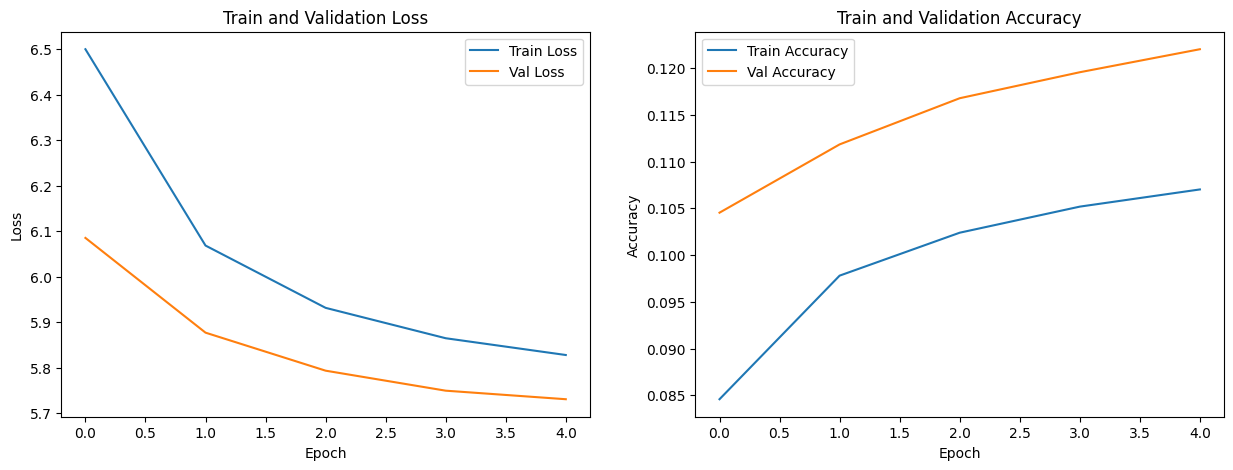

In [ ]:
import time
import torch.optim as optim
import matplotlib.pyplot as plt

epochs = 5
lr = 1e-4  # Taxa de aprendizado
criterion = nn.CrossEntropyLoss()  # Função de perda CrossEntropy

optimizer = optim.AdamW(model.parameters(), lr=lr)  # Otimizador AdamW

model.to(device)

# Função de Treinamento
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for contexts, targets in dataloader:
        contexts, targets = contexts.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(contexts)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * contexts.size(0)

        # Cálculo da acurácia
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    accuracy = correct / total
    return epoch_loss / len(dataloader.dataset), accuracy

# Função de Avaliação
def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for contexts, targets in dataloader:
            contexts, targets = contexts.to(device), targets.to(device)

            outputs = model(contexts)

            loss = criterion(outputs, targets)
            epoch_loss += loss.item() * contexts.size(0)

            # Cálculo da acurácia
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = correct / total
    return epoch_loss / len(dataloader.dataset), accuracy

# Loop de Treinamento e Avaliação com Tempo por Época
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        start_time = time.time()  # Captura o tempo inicial da época

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        end_time = time.time()  # Captura o tempo final da época
        epoch_time = (end_time - start_time) / 60  # Tempo da época em minutos

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - "
              f"Train Accuracy: {train_acc:.4f} - Val Accuracy: {val_acc:.4f} - "
              f"Time: {epoch_time:.2f} min")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Treinamento e Avaliação
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, epochs, device)

# Plotar Gráficos de Loss e Acurácia
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot de Loss
    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(val_losses, label='Val Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Train and Validation Loss')
    axs[0].legend()

    # Plot de Acurácia
    axs[1].plot(train_accuracies, label='Train Accuracy')
    axs[1].plot(val_accuracies, label='Val Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Train and Validation Accuracy')
    axs[1].legend()

    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


## Avaliação

In [ ]:
""" TODO: calcule a perplexidade final no dataset de validação """
val_perplexity = calculate_perplexity(model, val_loader, criterion, device)
print(f"Perplexidade no conjunto de validação: {val_perplexity:.2f}")

Perplexidade no conjunto de validação: 308.13


## Exemplo de uso

In [ ]:
# Função para gerar texto a partir de um modelo
def generate_text(model, context, max_length, context_size, device):
    model.eval()

    generated_indices = []
    context = context
    # Começar a geração de texto
    for _ in range(max_length):
        # Obter o contexto atual
        input_context = torch.tensor([101]+context[-context_size:]+[102], dtype=torch.long, device=device).unsqueeze(0)

        # Forward pass
        with torch.no_grad():
            output = model(input_context)

        # Obter o índice da palavra mais provável
        predicted_index = torch.argmax(output, dim=-1).item()

        # Adicionar o índice ao texto gerado
        generated_indices.append(predicted_index)

        # Atualizar o contexto
        context.append(predicted_index)
        context = context[-context_size:]

    # Decodificar os índices gerados para texto usando o tokenizer do BERT
    generated_text = tokenizer.decode(generated_indices)#, skip_special_tokens=True)

    return tokenizer.decode(context[:context_size]) + ' ' + generated_text

# Função para pegar um contexto aleatório do val_data
def get_random_context(val_text, context_size):
    # Escolha um índice aleatório para começar
    start_index = random.randint(0, len(val_text) - context_size)
    context = val_text[start_index:start_index + context_size]

    return context

# Exemplo de uso
context_size = 5
for i in range(5):
  context = get_random_context(val_text, context_size)
  context_text = tokenizer.decode(context)
  print("Contexto Inicial:", context_text)

  max_length = 75
  generated_text = generate_text(model, context, max_length, context_size, device)
  print(f"Texto gerado: {generated_text}")

Contexto Inicial: para mamãe, apres
Texto gerado: Não sei que não, que não é que não se não se lhe lhe deu a sua mãe, e não não, não, se se não é que o que me não me lembra. Não é que o que não é, que o que não me me parece. Não sei que não, mas. Não sei que não, mas. Não sei que não, mas. Não sei que não,
Contexto Inicial: ##ese uma alma jovem,
Texto gerado: que se não não fosse e a moça, e a que não podia ser, e não, que o que se não me disse o que lhe disse. Não sei, que se não não fosse o que o que, e não é o que me me lembra, e não se se não é, que não sei, mas, que não se lhe disse. Não sei, que se não não fosse
Contexto Inicial: do orçamento. Tinha a
Texto gerado: ..... que um pouco de um de outro, e a a a, e a a, que não lhe não podia ser....................................................
Contexto Inicial: verdade? acudia
Texto gerado: mas. Não sei que , que a não não ser a minha. Não é verdade. Não, é que o que não é, que o que não me me parece. Não sei que não, mas. Não sei 